First, check out this great cosine schedule

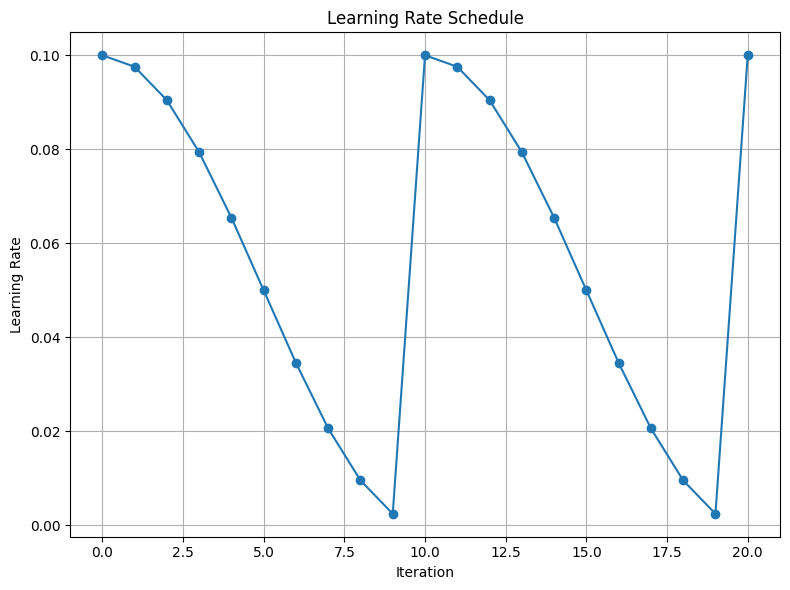

In [6]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
optim = AdamW(model.parameters(), lr=0.1)

sched = CosineAnnealingWarmRestarts(optim, T_0=10)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

Now let's imagine I ran training for a couple of steps…  
then saved (including the lr scheduler's state, i.e. what step it got to)…
then tried to resume.
We'd expect the graph to shift to the left.
Let's simulate this by:
- constructing a schedule with `last_epoch=5`.  
  this is equivalent to resuming from the 5th training step.  
  _it says epoch but it means training step._
- constructing the optimizer param groups with with an initial learning rate

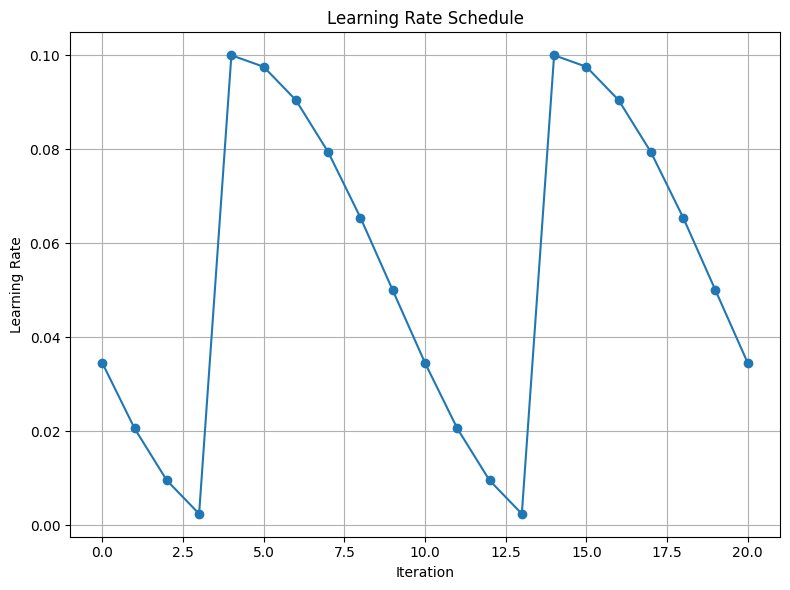

In [9]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
initial_lr=0.1
optim = AdamW([{
  'params': model.parameters(),
  'initial_lr': initial_lr,
}], lr=initial_lr)

sched = CosineAnnealingWarmRestarts(optim, T_0=10, last_epoch=5)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

That's one fine-looking resumed schedule.
Okay, can we resume from any step? Let's try resuming from further in the future (step 22):

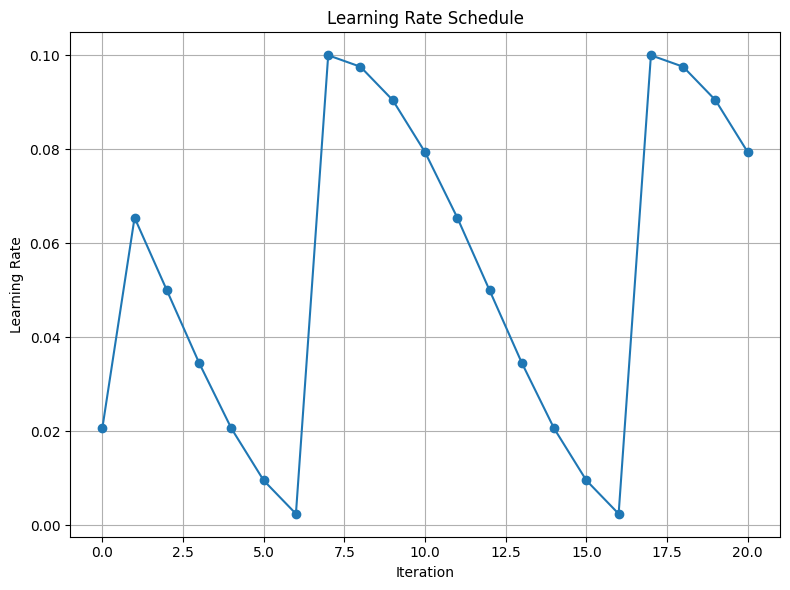

In [20]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
initial_lr=0.1
optim = AdamW([{
  'params': model.parameters(),
  'initial_lr': initial_lr,
}], lr=initial_lr)

sched = CosineAnnealingWarmRestarts(optim, T_0=10, last_epoch=22)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

wait a minute… there's no part of our schedule that looks like that!

and what happens if we go resume from even further in the future?

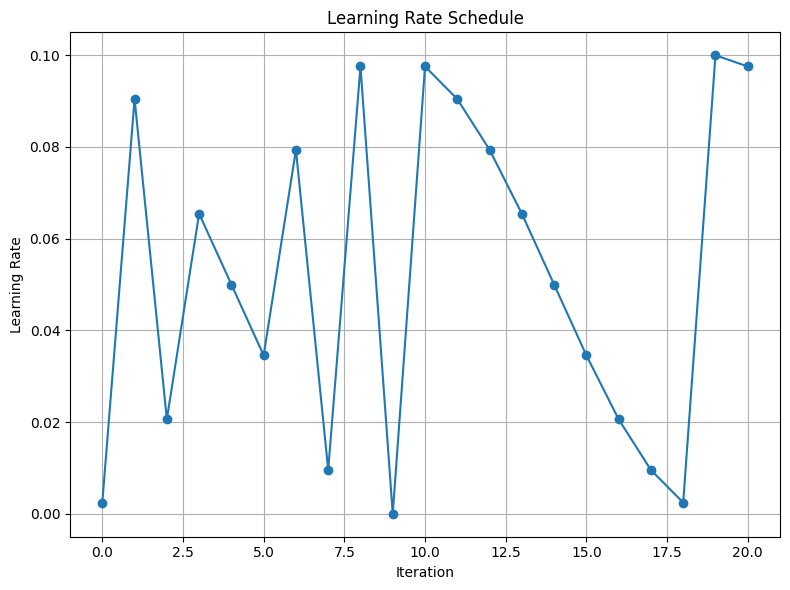

In [21]:
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
initial_lr=0.1
optim = AdamW([{
  'params': model.parameters(),
  'initial_lr': initial_lr,
}], lr=initial_lr)

sched = CosineAnnealingWarmRestarts(optim, T_0=10, last_epoch=100)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

That doesn't look cosine at all!  
![despair from Kogasa](http://birchlabs.co.uk/emoji/kogasadespair.webp)

It's because of [this stateful bit](https://github.com/pytorch/pytorch/blob/efb73fe8e4413a0d6db078e85c7ed7c91f05ca5d/torch/optim/lr_scheduler.py#L1411-L1413), which catches up `T_cur` and `T_i` to where they need to be for the given step.  
I think it only works for small step counts (i.e. stepping once, or resuming from a low number of steps).

I think changing the `if` to a `while` loop fixes the problem.

```diff
- if self.T_cur >= self.T_i:
+ while self.T_cur >= self.T_i:
    self.T_cur = self.T_cur - self.T_i
    self.T_i = self.T_i * self.T_mult
```

Let's try importing a copy of the scheduler with the fix applied:

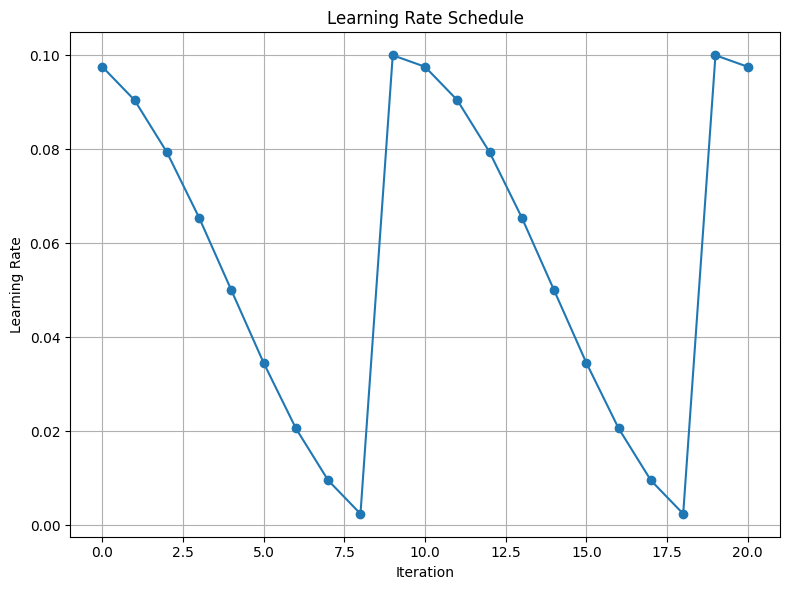

In [24]:
import sys
module_root = '..'
if module_root not in sys.path:
  sys.path.insert(0, module_root)
from importlib import reload

import src.cosine_annealing_warm_restarts_patched as Patched
# we reload the module every time the Jupyter cell is run, in case you wanted to make changes
# to that file and run this cell again and see your changes reflected
reload(Patched)

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
initial_lr=0.1
optim = AdamW([{
  'params': model.parameters(),
  'initial_lr': initial_lr,
}], lr=initial_lr)

sched = Patched.CosineAnnealingWarmRestarts(optim, T_0=10, last_epoch=100)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

That looks better.  
![thumbs up from Kita](http://birchlabs.co.uk/emoji/kita-thumbsup.webp)

Okay, but probably your boss will shout at you if you start rewriting code in `site-packages/torch`.  
Is there anything we can do until this fix makes it into a stable release of PyTorch?

Yes! We can make a questionable subclass of `CosineAnnealingWarmRestarts`, which runs the `while` loop we discussed.

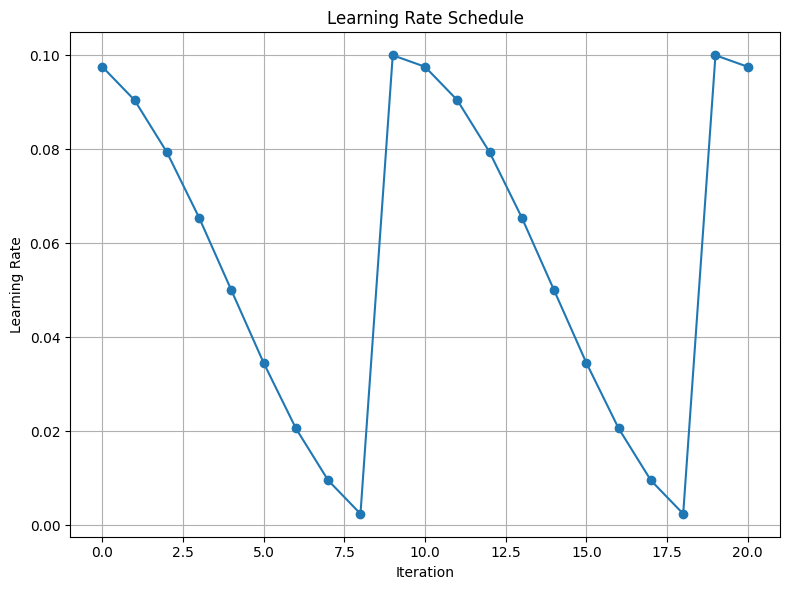

In [26]:
import sys
module_root = '..'
if module_root not in sys.path:
  sys.path.insert(0, module_root)
from importlib import reload

import src.cosine_annealing_warm_restarts_patched_subclass as PatchedSubclass
# we reload the module every time the Jupyter cell is run, in case you wanted to make changes
# to that file and run this cell again and see your changes reflected
reload(PatchedSubclass)

# from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.optim.adamw import AdamW
from torch.nn import Linear
from typing import List
import torch
import matplotlib.pyplot as plt

model = Linear(4, 3, bias=False, dtype=torch.float32)
initial_lr=0.1
optim = AdamW([{
  'params': model.parameters(),
  'initial_lr': initial_lr,
}], lr=initial_lr)

sched = PatchedSubclass.CosineAnnealingWarmRestartsFixedProbably(optim, T_0=10, last_epoch=100)

lrs: List[int] = []
lrs.append(optim.param_groups[0]['lr'])
for step in range(20):
  optim.step()
  sched.step()
  lrs.append(optim.param_groups[0]['lr'])

plt.figure(figsize=(8, 6))  # Optional: Set the figure size

plt.plot(lrs, marker='o', linestyle='-')

# Add labels and title
plt.xlabel('Iteration')
plt.ylabel('Learning Rate')
plt.title('Learning Rate Schedule')

# Show the plot
plt.grid(True)  # Optional: Add a grid
plt.tight_layout()  # Optional: Improve spacing
plt.show()

you could probably use this LR scheduler subclass without getting fired  
![Myne like this scheduler almost as much she does the printing press](http://birchlabs.co.uk/emoji/myne-sparkle.webp)